In [241]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.optimize import root
import pandas as pd
%matplotlib inline
import scienceplots
plt.style.use('nature')
plt.rc('font', family = 'serif')
plt.rc('figure', figsize = (8,6))
plt.rc('xtick', labelsize = 9) 
plt.rc('ytick', labelsize = 9) 
plt.rc('axes', titlesize = 14)
plt.rc('axes', labelsize = 12)

import astropy.constants as const
import astropy.units as u
G = const.G.value
c = const.c.value
Msun = const.M_sun.value

In [176]:
eos = np.genfromtxt('eos1.dat',names = ["nB" ,"energy_density", "pressure", "mu1", "mu2"])

In [162]:
eos = np.genfromtxt('eos1.dat',names = ["nB" ,"pressure", "energy_density", "mu1", "mu2"])

In [177]:
eos

array([(7.86637631e-15, 1.88643769e-19, 7.37866079e-12, 0.00075325,  938.        ),
       (2.48756661e-14, 1.20284928e-18, 2.33333752e-11, 0.00075325,  938.00006439),
       (7.86637631e-14, 7.66972793e-18, 7.37866174e-11, 0.00075325,  938.00019421),
       ...,
       (7.99760000e+00, 6.36721337e+03, 1.93108818e+04, 0.33333333, 3210.7251129 ),
       (7.99840000e+00, 6.36806947e+03, 1.93134501e+04, 0.33333333, 3210.83211566),
       (7.99920000e+00, 6.36892561e+03, 1.93160185e+04, 0.33333333, 3210.93911128)],
      dtype=[('nB', '<f8'), ('energy_density', '<f8'), ('pressure', '<f8'), ('mu1', '<f8'), ('mu2', '<f8')])

In [146]:
mask = np.isnan(eos['pressure'])

In [149]:
eos = eos[~mask]

In [242]:
eos = pd.read_csv('example_eos.dat', delimiter = ' ')

In [234]:
eos = pd.read_csv('eos_unified_FSUGarnet.dat', names = ["nB" ,"energy_density", "pressure"], skiprows = 1, delimiter = ' ')

In [243]:
eos

,energy_density,pressure
0,0.938098,0.000327
1,0.985034,0.000347
2,1.034284,0.000368
3,1.086017,0.000391
4,1.140338,0.000415
...,...,...
193,30316.339002,7806.157116
194,32236.178702,8366.596957
195,34281.117609,8970.859175
196,36459.619724,9619.856985


In [41]:
eos = np.genfromtxt("data/Baym_eos.dat", 
                         dtype=float, skip_header=1,
                         names=["energy_density", "pressure", "nB",])

In [163]:
eos['energy_density'] = (eos['energy_density']*u.MeV/u.fm**3).decompose()
eos['pressure'] = (eos['pressure']*u.MeV/u.fm**3).decompose()

In [205]:
eos['energy_density'] *= MeV_fm3_to_pa_cgs/c**2
eos['pressure'] *= MeV_fm3_to_pa_cgs

In [189]:
eos['energy_density'] = (eos['energy_density'].to_numpy()*u.MeV/u.fm**3).decompose()
eos['pressure'] = (eos['pressure'].to_numpy()*u.MeV/u.fm**3).decompose()

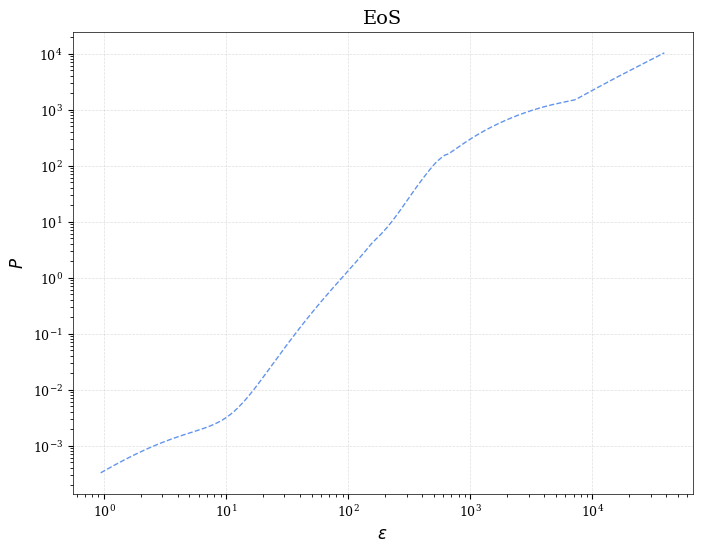

In [244]:
plt.plot(eos['energy_density'], eos['pressure'], color = 'cornflowerblue', linestyle = '--', markersize = 2)
plt.xlabel('$\epsilon$')
plt.ylabel('$P$')
plt.grid(alpha = 0.4, linestyle = '--')
plt.title('EoS')
plt.xscale('log')
plt.yscale('log')

In [207]:
eps = interp1d(eos['pressure'], eos['energy_density'], 'cubic')
press = interp1d(eos['energy_density'], eos['pressure'], kind='cubic')

In [208]:
TOV_PARAMS = {"minP": np.min(eos['pressure']), "maxP": np.max(eos['pressure']), "minE": np.min(eos['energy_density']), "maxE": np.max(eos['energy_density'])}

In [209]:
def tov(y, r):
    P, m = y
    
    if P < TOV_PARAMS['minP'] or P > TOV_PARAMS['maxP']:
        return [0,0]
    
    edens = eps(P)
    dp_dr = (-G * ( edens + P / c**2) * (m + 4*np.pi*(r** 3)* P / c**2) ) / (r * (r - 2*G*m/c**2))
    dm_dr = 4*np.pi*(r**2)*edens
    
    return [dp_dr, dm_dr]

In [210]:
def solve_tov(e_c, r_max = 300e5, dmrel=10e-12, dr=100):

    e_c *= MeV_fm3_to_pa_cgs/c**2
    r = np.arange(dr, r_max + dr, dr)

    P = press(e_c)
    edens = eps(P)
    m = 4.0 * np.pi * (r[0] ** 2) * edens

    psol = odeint(tov, [P, m], r, rtol = 1e-5)

    p_R, m_R = psol[:,0], psol[:,1]
    
    del_slope = np.ediff1d(m_R[1:] - m_R[:-1])
    ind = np.argmin(del_slope)

    M = m_R[ind - 1]
    R = r[ind - 1]

    r   = r[:ind]
    p_R = p_R[:ind]
    m_R = m_R[:ind]
    
    e_R = eps(p_R)
    
    return R / 1e5, M / Msun, (r, e_R, p_R, m_R)

In [211]:
r = np.arange(10, 20e3, 10)

P = press(1e18)
edens = eps(P)
m = 4.0 * np.pi * (r[0] ** 3) * edens / c**2
print(m/Msun)

psol = odeint(tov, [P, m], r, rtol = 1e-5)

7.031738200400886e-26
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000000000000D+02   r2 =  0.3518508453342D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000000000000D+02   r2 =  0.3518508453342D-18


In [212]:
p_R, m_R = psol[:,0], psol[:,1]

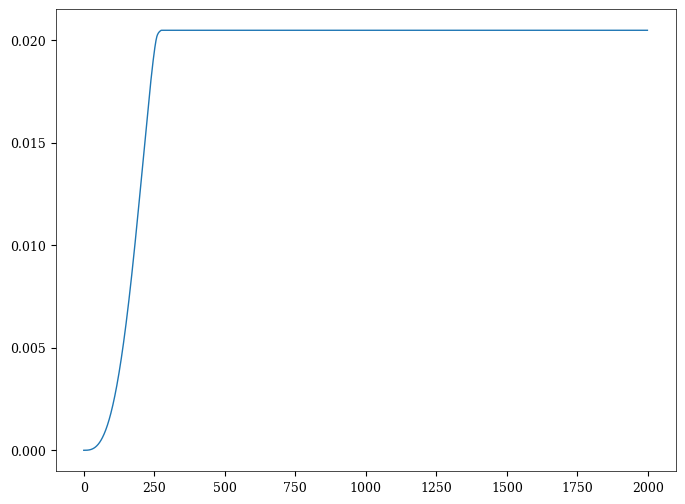

In [213]:
plt.plot(m_R/Msun)

In [214]:
np.ediff1d(m_R[1:] - m_R[:-1])

array([5.02619215e+22, 7.53846562e+22, 1.00497566e+23, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

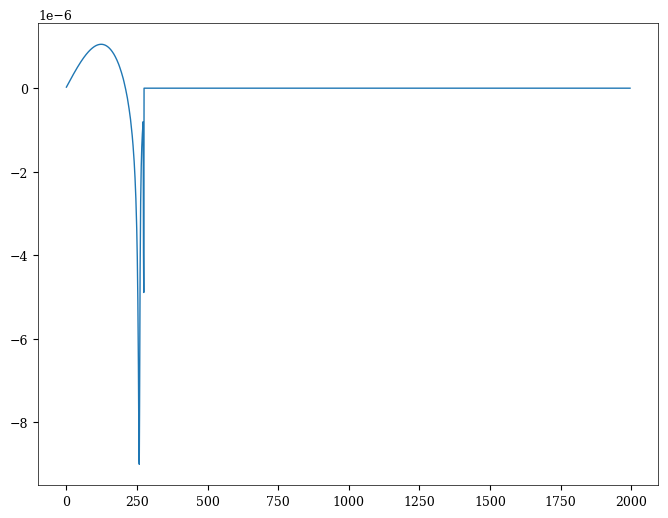

In [215]:
plt.plot(np.ediff1d(m_R[1:] - m_R[:-1])/Msun)

In [224]:
o1, o2, o3 = solve_tov(5000)

In [225]:
o1, o2

(0.03, 0.5794768321376822)

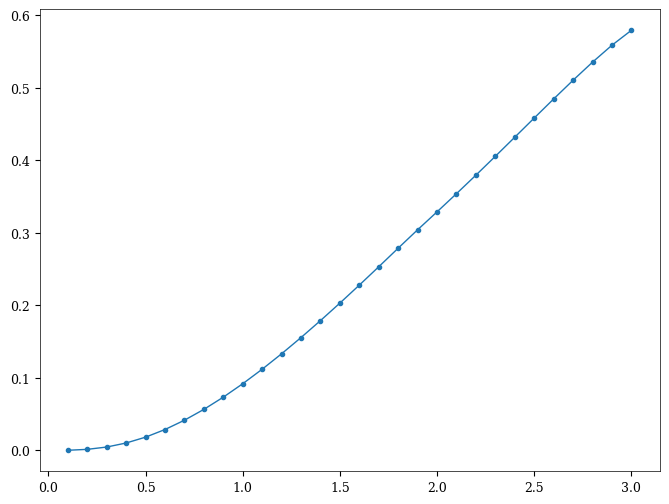

In [226]:
plt.plot(o3[0]/1e3, o3[-1]/Msun, marker = 'o')

In [222]:
m_arr = []
R_arr = []
dc = []

for dens_c in np.logspace(-0, 3.7, 350):
    try:
        R, M, prof = solve_tov(dens_c, r_max=5e5, dr=10)
        m_arr.append(M)
        R_arr.append(R)
        dc.append(dens_c)
    except:
        pass

/home/aswin/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


(6.0, 20.0)

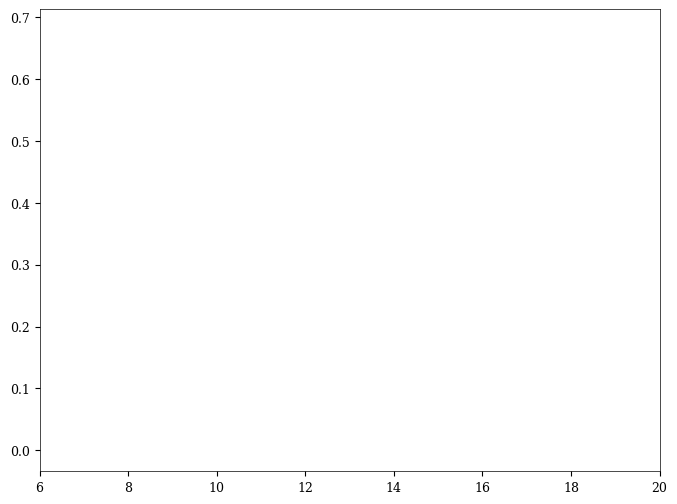

In [223]:
plt.plot(R_arr, m_arr)
plt.xlim(6, 20)

In [435]:
eos['energy_density'] = eos['energy_density']*u.MeV/u.fm**3

In [436]:
eos['pressure'] = eos['pressure']*u.MeV/u.fm**3

In [447]:
(eos['energy_density'].to_numpy()*u.MeV/u.fm**3).decompose()

<Quantity [1.50299869e+32, 1.57819913e+32, 1.65710559e+32, 1.73999126e+32,
           1.82702309e+32, 1.91840849e+32, 2.01436511e+32, 2.11512181e+32,
           2.22091860e+32, 2.33200737e+32, 2.44865322e+32, 2.57113369e+32,
           2.69974106e+32, 2.83478153e+32, 2.97657695e+32, 3.12546493e+32,
           3.28180048e+32, 3.44595587e+32, 3.61832239e+32, 3.79931047e+32,
           3.98935159e+32, 4.18889816e+32, 4.39842582e+32, 4.61843353e+32,
           4.84944537e+32, 5.09201167e+32, 5.34671023e+32, 5.61414762e+32,
           5.89496080e+32, 6.18981900e+32, 6.49942420e+32, 6.82451401e+32,
           7.16586246e+32, 7.52428257e+32, 7.90062825e+32, 8.29579572e+32,
           8.71072643e+32, 9.14640847e+32, 9.60387963e+32, 1.00842301e+33,
           1.05886034e+33, 1.11182019e+33, 1.16742870e+33, 1.22581838e+33,
           1.28712842e+33, 1.35150489e+33, 1.41910130e+33, 1.49007879e+33,
           1.56460667e+33, 1.64286264e+33, 1.72503347e+33, 1.81131525e+33,
           1.90191392e+33

In [397]:
P = press(200)*u.MeV/u.fm**3
edens = eps(P)*u.MeV/u.fm**3

In [398]:
r = 1*u.km
m = (4.0 * np.pi * (r ** 3) * edens/c **2)

In [399]:
edens + P

<Quantity 207.1416332 MeV / fm3>

In [400]:
(G * ( (edens + P) / c**2) * (m + 4*np.pi*(r** 3)* P / c**2))

<Quantity 4.45520373e-39 km3 MeV2 s2 / (kg m fm6)>

In [358]:
r - 2*G*m/c**2

<Quantity 0.99334568 km>

In [402]:
((-G * ( (edens + P) / c**2) * (m + 4*np.pi*(r** 3)* P / c**2)) / (r * (r - 2*G*m/c**2))).decompose()

<Quantity -1.15129852e+29 kg / (m2 s2)>

In [416]:
(4*np.pi*(r**2)*edens/c**2).decompose()

<Quantity 4.48032112e+24 kg / m>

In [411]:
(-(G/c**2)*((P + edens) * (m + 4*np.pi*r**3*P/c**2))/(r * (r - 2*G*m/c**2))).to(u.MeV/u.fm**4)

<Quantity -7.18584017e-19 MeV / fm4>

In [250]:
m_arr = []
R_arr = []

for dens_c in np.logspace(-0,3.7,350):
    try:
        R, M, prof = solve_tov(dens_c, rmax=50e5, dr=100)
        m_arr.append(M)
        R_arr.append(R)
    except:
        pass

/home/aswin/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


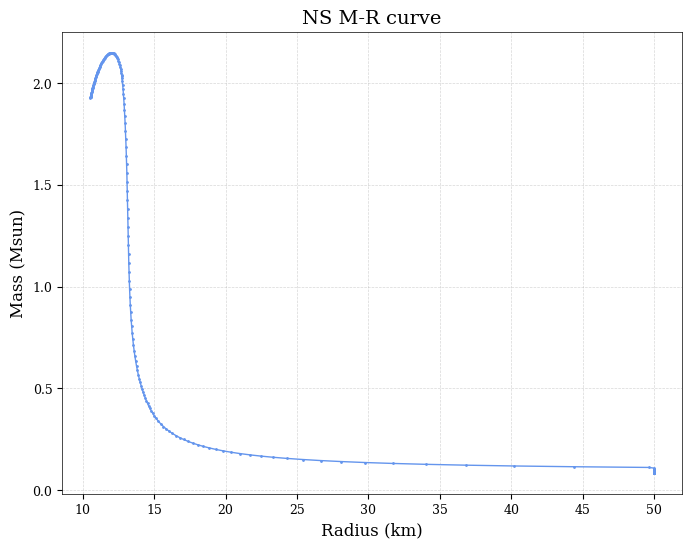

In [254]:
# plt.plot(R_arr1, m_arr1)
plt.plot(R_arr, m_arr, marker = 'o', color = 'cornflowerblue', markersize = 1)
plt.grid(alpha = 0.5, linestyle = '--')
plt.title('NS M-R curve')
plt.xlabel('Radius (km)')
plt.ylabel('Mass (Msun)')
plt.savefig('mr.png', dpi = 300, bbox_inches = 'tight')